# Kaggle Diabetic Retinopathy - Milestone 1 (NumPy Only)

## 1. Introduction
In this notebook, we implement a solution for the Kaggle Diabetic Retinopathy competition (Milestone 1) using **only NumPy**, as required. We will explore the data, preprocess it, implement k-NN and MLP models from scratch, compare their performance, and generate a submission file.

## 2. Data Exploration

Loading Train Data...
Images shape: (1080, 28, 28, 3)
Labels shape: (1080, 1)


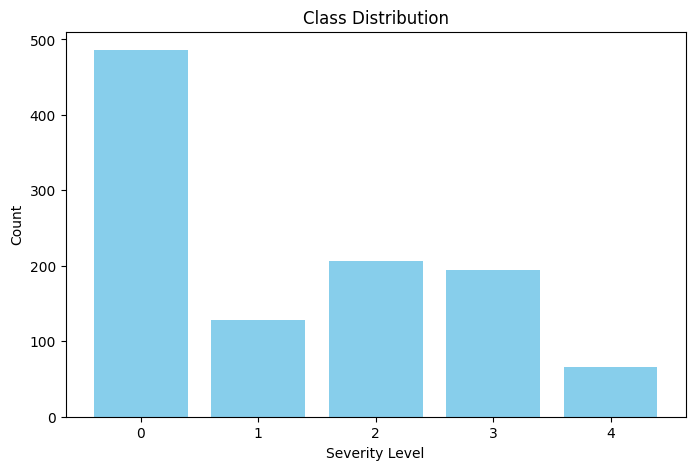

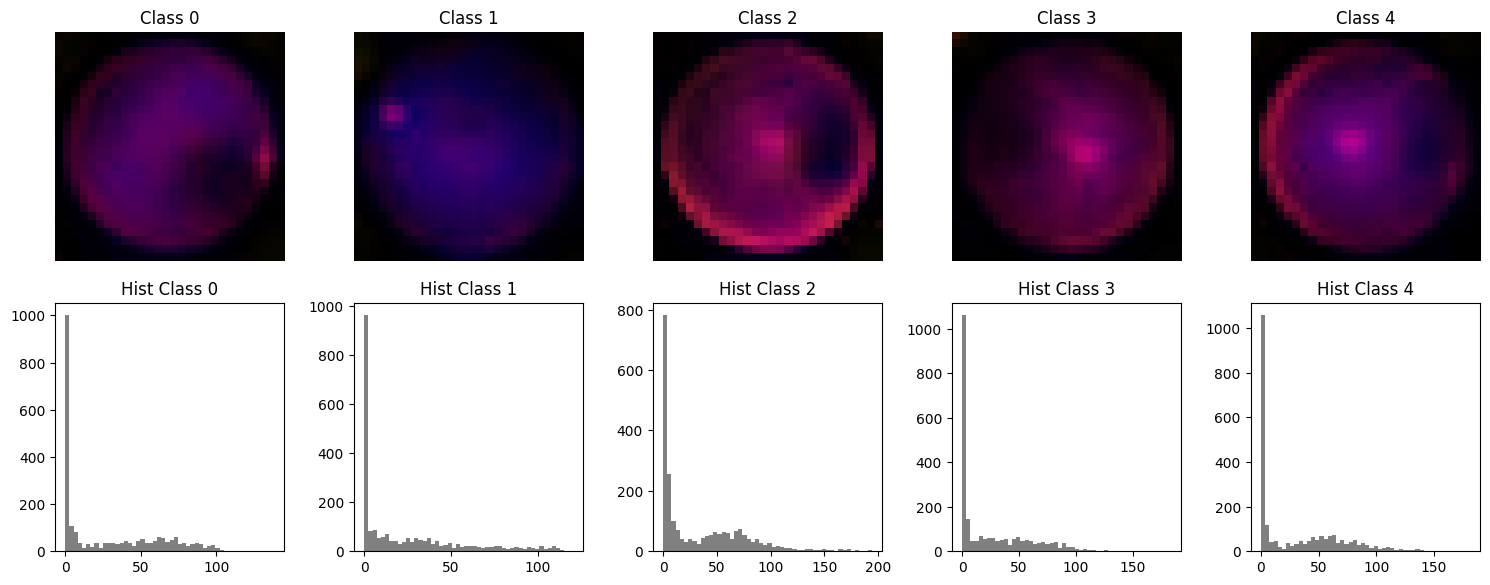

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load Data
def load_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

print("Loading Train Data...")
train_data = load_data('data/train_data.pkl')
X_raw = train_data['images']
y_raw = train_data['labels']

print(f"Images shape: {X_raw.shape}")
print(f"Labels shape: {y_raw.shape}")

# Visualize Class Distribution
unique, counts = np.unique(y_raw, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique, counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.xticks(unique)
plt.show()

# Visualize Sample Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Find first image of each class
    idx = np.where(y_raw == i)[0][0]
    img = X_raw[idx]
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Class {i}")
    axes[0, i].axis('off')
    
    # Show histogram of pixel intensities
    axes[1, i].hist(img.ravel(), bins=50, color='gray')
    axes[1, i].set_title(f"Hist Class {i}")

plt.tight_layout()
plt.show()

## 3. Data Preprocessing
We normalize the pixel values to [0, 1] and flatten the images from (28, 28, 3) to a vector of size 2352.

In [2]:
def preprocess_data(images, mode='flatten'):
    # Normalize
    images = images.astype(np.float32) / 255.0
    
    if mode == 'flatten':
        # Flatten: (N, 28, 28, 3) -> (N, 2352)
        N = images.shape[0]
        images = images.reshape(N, -1)
        
    return images

X = preprocess_data(X_raw)
y = y_raw.flatten()

print(f"Processed X shape: {X.shape}")
print(f"Processed y shape: {y.shape}")

Processed X shape: (1080, 2352)
Processed y shape: (1080,)


## 4. Model Implementation

### 4.1 k-Nearest Neighbors (k-NN)

In [3]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        
        # Vectorized L2 Distance
        x_sq = np.sum(X**2, axis=1, keepdims=True)
        y_sq = np.sum(self.X_train**2, axis=1, keepdims=True).T
        xy = np.dot(X, self.X_train.T)
        dists = np.sqrt(np.maximum(0, x_sq + y_sq - 2 * xy))
        
        return self._predict_labels(dists)

    def _predict_labels(self, dists):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            closest_y = []
            sorted_indices = np.argsort(dists[i])
            closest_indices = sorted_indices[:self.k]
            closest_y = self.y_train[closest_indices]
            
            counts = np.bincount(closest_y.flatten())
            y_pred[i] = np.argmax(counts)

        return y_pred

### 4.2 Multi-Layer Perceptron (MLP)

In [4]:
class MLPClassifier:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = learning_rate
        
        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        
        # Xavier initialization
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        self.loss_history = []
        
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_deriv(self, Z):
        return Z > 0
    
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2
    
    def compute_loss(self, y_true_one_hot, y_pred):
        m = y_true_one_hot.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true_one_hot.argmax(axis=1)] + 1e-9)
        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward(self, X, y_true_one_hot, y_pred):
        m = X.shape[0]
        dZ2 = y_pred - y_true_one_hot
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_deriv(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        
    def train(self, X, y, epochs=100, batch_size=32, verbose=True):
        num_samples = X.shape[0]
        num_classes = self.output_size
        y_one_hot = np.zeros((num_samples, num_classes))
        y_one_hot[np.arange(num_samples), y.flatten()] = 1
        
        for epoch in range(epochs):
            indices = np.random.permutation(num_samples)
            X_shuffled = X[indices]
            y_shuffled = y_one_hot[indices]
            
            epoch_loss = 0
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += loss
                self.backward(X_batch, y_batch, y_pred)
            
            avg_loss = epoch_loss / (num_samples / batch_size)
            self.loss_history.append(avg_loss)
            
            if verbose and (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
                
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

## 5. Model Comparison
We split the data into training (80%) and validation (20%) sets to compare k-NN and MLP.

Evaluating k-NN (k=5)...
k-NN Accuracy: 0.4537

Evaluating MLP (Hidden=128, LR=0.01, Epochs=200)...
Epoch 20/200, Loss: 1.2536
Epoch 40/200, Loss: 1.2109
Epoch 60/200, Loss: 1.1836
Epoch 80/200, Loss: 1.1656
Epoch 100/200, Loss: 1.1498
Epoch 120/200, Loss: 1.1398
Epoch 140/200, Loss: 1.1176
Epoch 160/200, Loss: 1.1050
Epoch 180/200, Loss: 1.0981
Epoch 200/200, Loss: 1.0719
MLP Accuracy: 0.4907


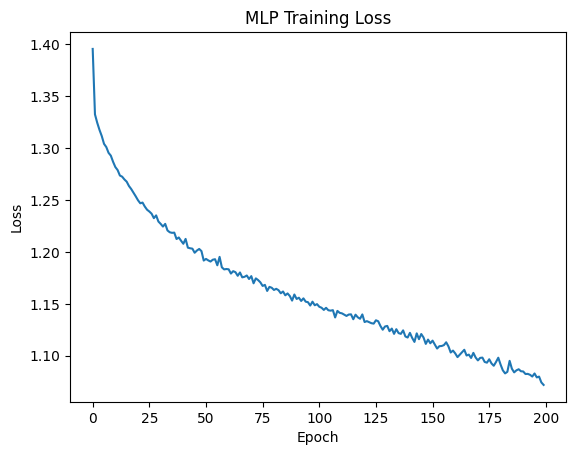

In [5]:
def get_train_val_split(X, y, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(X))
    val_size = int(len(X) * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    return X[train_indices], y[train_indices], X[val_indices], y[val_indices]

X_train, y_train, X_val, y_val = get_train_val_split(X, y)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

# --- Evaluate k-NN ---
print("Evaluating k-NN (k=5)...")
knn = KNNClassifier(k=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)
acc_knn = accuracy_score(y_val, y_pred_knn)
print(f"k-NN Accuracy: {acc_knn:.4f}")

# --- Evaluate MLP ---
print("\nEvaluating MLP (Hidden=128, LR=0.01, Epochs=200)...")
mlp = MLPClassifier(input_size=X.shape[1], hidden_size=128, output_size=5, learning_rate=0.01)
mlp.train(X_train, y_train, epochs=200, verbose=True)
y_pred_mlp = mlp.predict(X_val)
acc_mlp = accuracy_score(y_val, y_pred_mlp)
print(f"MLP Accuracy: {acc_mlp:.4f}")

# Plot Loss Curve
plt.plot(mlp.loss_history)
plt.title('MLP Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 6. Submission Generation
We retrain the best model (MLP) on the full dataset and generate predictions for the test set.

In [6]:
import pandas as pd

print("Retraining MLP on full dataset...")
mlp_final = MLPClassifier(input_size=X.shape[1], hidden_size=128, output_size=5, learning_rate=0.01)
mlp_final.train(X, y, epochs=200, verbose=False)

print("Loading Test Data...")
test_data = load_data('data/test_data.pkl')
X_test_raw = test_data['images']
X_test = preprocess_data(X_test_raw)

print("Predicting on Test Set...")
y_test_pred = mlp_final.predict(X_test)

# Create Submission CSV
ids = np.arange(1, len(y_test_pred) + 1)
df = pd.DataFrame({'ID': ids, 'Label': y_test_pred})
df.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")
df.head()

Retraining MLP on full dataset...
Loading Test Data...
Predicting on Test Set...
Submission saved to submission.csv


,ID,Label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
